# LED Data Analysis Using Tool Functions
## Import the Libraries

In [1]:
import sys,os
import time 
import h5py

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.special import expit

sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import MB_equations as MBe
import MB_analysis as MBa
import TimestreamHelperFunctions as Thf
import OptFilterTools as oft

## Define the MB Parameters

In [2]:
## MB Results come from fitting a temperature scan at a specified RF power
use_nexus_MBvals = False

if use_nexus_MBvals:
    ## As measured in NEXUS
    MB_fit_vals = np.array([4.24216+9.75e-6, 
                            0.177  ,
                            0.0125 ,
                            4.1e7  ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
else:
    ## As measured on Caltech sister device (https://arxiv.org/pdf/2111.08064.pdf)
    MB_fit_vals = np.array([4.24201000, 
                            0.184     ,
                            0.03801   ,
                            4.05538e5 ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
    
## How much attenuation is in the lines before the chip
line_atten_dB = 56.5

## Define the PSD Parameters

In [3]:
## PSD hi and lo frequency limits
chunk_up_to      = 1e1
decimate_down_to = 5e4

## Transient period at front of timestream
blank_fraction = 0.1

## Removal decimation for cleaning (more == better high-F cleaning)
removal_dec    = 10

## Pull the Data Files

In [4]:
datapath = '/data/USRP_Laser_Data'
series   = "20230215_152558"
# series   = "20230713_152558"

sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, 
                                                        base_path=datapath,
                                                        sep_noise_laser=True,
                                                        verbose=False)

n_runs   = len(led_files)
for f in nse_files:
    print(f)

/data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_11.h5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_14.h5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_2.h5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_5.h5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_8.h5


## Extract Voltage and Pulse Profile Information

In [5]:
voltages, p_params, charFs, charZs = oft.parse_metadata(sum_file, 
                                                        blank_fraction=blank_fraction, 
                                                        verbose=True)

RF Power at USRP: -15 dBm
Char. freqs:  [[4241.950653 4241.951542 4241.95243 ]
 [4241.950653 4241.951542 4241.95243 ]
 [4241.950653 4241.951542 4241.95243 ]
 [4241.950653 4241.951542 4241.95243 ]
 [4241.950653 4241.951542 4241.95243 ]
 [4241.950653 4241.951542 4241.95243 ]]
Char. S21s:   [[0.14956476+0.08013122j 0.1498773 +0.08678613j 0.14890199+0.09287615j]
 [0.15040469+0.07583644j 0.15012718+0.08261491j 0.14908874+0.09027844j]
 [0.1494241 +0.07613812j 0.14886481+0.08330118j 0.14855173+0.09001141j]
 [0.14935637+0.0757731j  0.14845795+0.08317396j 0.14821089+0.0906626j ]
 [0.14941679+0.07604463j 0.14836464+0.08355995j 0.14830992+0.09014706j]
 [0.14901095+0.0768632j  0.14810257+0.08433052j 0.14803194+0.09122225j]]
Duration: 200.0 sec
Pulse f:  5.0 Hz
Pls wdth: 2.0 us
P  delay: 5.0 ms
Total pulse windows in acq.:  1000.0
Time between pulse arrival:   0.2 sec
Number of windows to look at: 900


## Noise Cleaning and PSDs

In [6]:
for i in np.arange(len(nse_files)):
    powers, PSDs, res, timestreams = Thf.CleanPSDs(nse_files[i], vna_file, 
        PSD_lo_f=chunk_up_to, 
        PSD_hi_f=decimate_down_to, 
        rem_dec=removal_dec,
        f_transient=blank_fraction, 
        charFs=charFs[i].real, 
        charZs=charZs[i],
        show_plots=False, verbose=False)

pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5 because override=True!
found 1 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_11.h5 because override=True!
found 6 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_11_cleaned.h5 because override=True!
Converting to resonator basis!
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Dat

## Define the Files To Process

In [7]:
## Look at phase or log-mag
PHASE = True

files_to_skip = 0 ## How many to skip at beginning
files_to_trim = 0 ## How many to cut off at end

# LED_files = led_files[files_to_skip:n_runs-files_to_trim]
# Voltages  = voltages[files_to_skip:n_runs-files_to_trim]

LED_files = led_files[::2]
Voltages  = voltages[::2]

LED_files = LED_files[Voltages != 5.50]
Voltages  = Voltages[ Voltages != 5.50]

for i in np.arange(len(LED_files)):
    print(LED_files[i],":",Voltages[i])

/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558.h5 : 2.0
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.500V_20230713_152558.h5 : 2.5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.000V_20230713_152558.h5 : 3.0
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.500V_20230713_152558.h5 : 3.5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.000V_20230713_152558.h5 : 4.0
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.500V_20230713_152558.h5 : 4.5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_5.000V_20230713_152558.h5 : 5.0
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_6.000V_20230713_152558.h5 : 6.0


## Pulse window plotting

In [8]:
pulse_rqs = oft.plot_all_pulse_windows(LED_files, nse_files[0], vna_file, p_params, 
    p1=5, p2=90, decimate_down_to=None, pulse_cln_dec=4,
    PHASE=PHASE, show_plots=False)

plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.500V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.000V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Las

## Define Cuts

In [9]:
re_save = False

cut_df = oft.define_default_cuts(LED_files, pulse_rqs, PHASE=PHASE, p1=5, p2=90, force_save=re_save)

# _i = np.argmin(np.abs(Voltages - 2.00))
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_min", np.nan)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", np.nan)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_min", np.nan)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", np.nan)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "wfmx_min", np.nan)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "wfmx_max", np.nan)

_i = 0 ## 2.00 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.503)
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

_i += 1 ## 2.50 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.499)
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

_i += 1 ## 3.00 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.499)
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

_i += 1 ## 3.50 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

_i += 1 ## 4.00 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.501)
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

_i += 1 ## 4.50 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.501)
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

_i += 1 ## 5.00 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.500)
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

# _i = 7 ## 5.50 V
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.619)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0047)

_i += 1 ## 6.00 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.504)
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

if re_save:
    oft.save_cut_df(cut_df, LED_files, PHASE=PHASE)

cut_df

,sdev_min,sdev_max,mean_min,mean_max
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558.h5,0.002274,0.003,0.492217,0.5030
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.500V_20230713_152558.h5,0.002261,0.003,0.486855,0.4990
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.000V_20230713_152558.h5,0.002288,0.003,0.487219,0.4990
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.500V_20230713_152558.h5,0.002287,0.003,0.488959,0.5039
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.000V_20230713_152558.h5,0.002282,0.003,0.490437,0.5010
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.500V_20230713_152558.h5,0.002300,0.003,0.485353,0.5010
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_5.000V_20230713_152558.h5,0.002277,0.003,0.490312,0.5000
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_6.000V_20230713_152558.h5,0.002294,0.003,0.488148,0.5040


In [10]:
bad_pls_idxs = oft.get_all_bad_pulse_idxs(LED_files, cut_df, pulse_rqs, 
                                          z_pre=3.5, z_post=5.0, z_full=6.0, 
                                          PHASE=PHASE, verbose=True)

USRP_LaserOn_2.000V_20230713_152558.h5 : 661 bad pulses 73.4%
USRP_LaserOn_2.500V_20230713_152558.h5 : 628 bad pulses 69.7%
USRP_LaserOn_3.000V_20230713_152558.h5 : 553 bad pulses 61.4%
USRP_LaserOn_3.500V_20230713_152558.h5 : 446 bad pulses 49.5%
USRP_LaserOn_4.000V_20230713_152558.h5 : 613 bad pulses 68.1%
USRP_LaserOn_4.500V_20230713_152558.h5 : 511 bad pulses 56.7%
USRP_LaserOn_5.000V_20230713_152558.h5 : 480 bad pulses 53.3%
USRP_LaserOn_6.000V_20230713_152558.h5 : 462 bad pulses 51.3%


In [11]:
_ = oft.plot_all_pulse_windows(LED_files, nse_files[0], vna_file, p_params, 
    bad_pls_idxs = bad_pls_idxs,
    p1=5, p2=90, decimate_down_to=None, pulse_cln_dec=4,
    PHASE=PHASE, show_plots=False)
del _

plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.500V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.000V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Las

In [12]:
## Free up some memory
del pulse_rqs, cut_df

In [13]:
oft.clean_all_pulse_windows(LED_files, nse_files[0], vna_file, p_params, bad_pls_idxs, 
                            frac_to_keep=0.5,
                            decimate_down_to=None, 
                            pulse_cln_dec=4,
                            PHASE=PHASE, show_plots=False)

cleaning pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
saving clean_data to /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.500V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
saving clean_data to /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.500V_20230713_152558_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.000V_20230713_152558.h5
u

In [14]:
oft.get_all_average_pulse(LED_files, vna_file, p_params, bad_pls_idxs, 
                          extra_decimation=1, 
                          fraction_to_keep=0.5, 
                          window_shift_seconds=0, 
                          PHASE=PHASE, save_shape=True, show_plots=False, verbose=False)

averaging pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558.h5
Used 239 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.500V_20230713_152558.h5
Used 272 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.000V_20230713_152558.h5
Used 347 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.500V_20230713_152558.h5
Used 454 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.000V_20230713_152558.h5
Used 287 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.500V_20230713_152558.h5
Used 389 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_5.000V_20230713_152558.h5
Used 420 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230713/20

In [15]:
%matplotlib notebook
## Create a colormap for plotting different LED powers
cmap   = plt.get_cmap('OrRd')

# plt.rcParams.update({'font.size': 18})

In [16]:
p_params.keys()

dict_keys(['rf_power', 'n_volts', 'lapse_sec', 'LED_rate_Hz', 'pulse_w', 'delay_ms', 'total_pulses', 'time_btw_pulse', 'num_pulses', 'blank_fraction'])

In [17]:
oft.align_all_pulses(LED_files, nse_files, vna_file, sum_file, p_params, charFs, charZs, MB_fit_vals, Voltages,
                     fraction_to_keep=0.5, tw_min_us=8000, tw_max_us=10000, data_T_K=10.0e-3)

cleaning pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_6.000V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using summary file:  /data/USRP_Laser_Data/20230713/20230713_152558/noise_averages_20230713_152558.h5
Fr from fit  [GHz]: 4.24195154162525
Fr min curve [GHz]: 4.241951646175839
Fr from fit  [GHz]: 4.24195154162525
Fr min curve [GHz]: 4.241951646175839
Using df/f readout
Saving clean pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_6.000V_20230713_152558_cleaned.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

cleaning pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_5.000V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using summary file:  /data/USRP_Laser_Data/20230713/20230713_152558/noise_averages_20230713_152558.h5
Fr from fit  [GHz]: 4.24195154162525
Fr min curve [GHz]: 4.241951646175839
Fr from fit  [GHz]: 4.24195154162525
Fr min curve [GHz]: 4.241951646175839
Using df/f readout
Saving clean pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_5.000V_20230713_152558_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.500V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using summary file:  /data/USRP_Laser_Data/20230713/20230713_152558/noise_averages_20230713_152558.h5
Fr from fit  [GHz]: 4.24195154162525
Fr min curve [GHz]: 4.241951646175839
Fr from fit  [GHz]: 4.24195

{'/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_6.000V_20230713_152558.h5': 6.96625263820683e-07,
 '/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_5.000V_20230713_152558.h5': 5.339011581663602e-07,
 '/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.500V_20230713_152558.h5': 4.4240713362757675e-07,
 '/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.000V_20230713_152558.h5': 3.4163901714163494e-07,
 '/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.500V_20230713_152558.h5': 2.3622078877212594e-07,
 '/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.000V_20230713_152558.h5': 1.2165068710144806e-07,
 '/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.500V_20230713_152558.h5': 1.4501784685366674e-08,
 '/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558.h5': 1.963137627402124e-09}

In [18]:
# ## Initialize an index to count files as we loop
# i = 0

# fraction_to_keep = 0.5

# ## Open the cleaned data and pull the data sampling rate, pulse template, and pulse noise
# with h5py.File(LED_files[0][:-3] + '_cleaned.h5', "r") as fyle:
#     sampling_rate = np.array(fyle['sampling_rate'])

# ## Define the time window for the pulse-full region, in microseconds
# time_window_range = fraction_to_keep * p_params['time_btw_pulse'] *1e6
# time_window = np.arange(0,time_window_range,1/sampling_rate*1e6)#[:-1]

# ## Define the time window in microseconds that will be used to align the pulses later
# tw_min =  8000 # 200 # 3000 # 
# tw_max = 10000 # 300 # 4000 # 
# # time_window = np.arange(-200,time_window_range-200,1/sampling_rate*1e6)
# # time_window = np.arange(window_shift_seconds*1e6,time_window_range+window_shift_seconds*1e6,1/sampling_rate*1e6)

# ## Create some strings to use as plot titles and handles later
# AWF_string = str(int(10*p_params['pulse_w'])/10) + " us"
# title_1    = 'power ' + str(p_params['rf_power']) + '; AWF ' + AWF_string + ': pulses in S21'
# title_1p5  = 'power ' + str(p_params['rf_power']) + '; AWF ' + AWF_string + ': pulses in S21, zoomed in'
# title_1p75 = 'alignment of pulses using largest pulse (blue)' 
# # title_2    = 'S_21 pulse height along pulse alignment axis'
# title_2    = 'Average Pulse Shapes'

# ## Pull the readout frequency from the characterization data
# ## then get the VNA data for this run
# readout_f = charFs[0,1].real
# f,z = PUf.read_vna(vna_file)

# ## Loop over the full list of LED files (the reversed order is no longer important)
# for pulse_file in LED_files[::-1]:
#     print('===================')
#     print('cleaning pulse file:',pulse_file)
#     print('using VNA file:     ',vna_file)
#     print('using summary file: ',sum_file)
#     char_file = sum_file

#     ## Get the cleaned data and average pulse
#     clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
#     with h5py.File(clean_pulse_file, "r") as fyle:
#         pulse_avg = np.array(fyle["pulse_shape"],dtype=np.complex128)
#         pulse_timestream = np.array(fyle["cleaned_data"],dtype=np.complex128)

#     ## Get the timestreams and average pulse in resonator basis
#     df_f, d1_Q, _, _ = Prf.resonator_basis(pulse_avg,readout_f*1e-3,f*1e-3,z,charFs[0].real*1e-3,charZs[0])#,plot_title='power ' + power_directories[j][:-1] + ' AWF ' + AWF_string)
#     df_f_timestream, d1_Q_timestream, _, _ = Prf.resonator_basis(pulse_timestream[:,0],readout_f*1e-3,f*1e-3,z,charFs[0].real*1e-3,charZs[0])
#     # plt.axis([0.058, 0.062, -0.19, -0.15])
    
#     ## Get the timestreams and average pulse in quasiparticle basis
#     dk1, dk2, =                       Prf.quasiparticle_basis(df_f, d1_Q,
#                                                               data_T     = 10.0e-3, 
#                                                               MB_results = MB_fit_vals,
#                                                               readout_f  = readout_f*1e-3)
#     dk1_timestream, dk2_timestream, = Prf.quasiparticle_basis(df_f_timestream, d1_Q_timestream,
#                                                               data_T     = 10.0e-3, 
#                                                               MB_results = MB_fit_vals,
#                                                               readout_f  = readout_f*1e-3)

#     ## Baseline(mean)-subtract the average pulse, then find its stdev
#     ## Using the last five samples of the average pulse to get mean, sdev
#     pulse_avg_mb = pulse_avg - np.mean(pulse_avg[-5:],dtype=np.complex128)
#     std = np.std(abs(pulse_avg_mb[-5:]),dtype=np.complex128)
    
#     ## Calculate the average angle of the average pulse in the specified alignment window
#     average_angle = np.mean(np.angle(pulse_avg_mb[np.logical_and(time_window>tw_min,time_window<tw_max)]))
    
#     ## Baseline(mean)-subtract the (raw) pulse timestream for the on-resonance tone
#     ## Again using the last five samples of the average pulse to get mean
#     pulse_timestream_mb = pulse_timestream[:,0] - np.mean(pulse_avg[-5:],dtype=np.complex128)

#     ## Apply the rotation by the average angle to the baseline-subtracted timestream and average pulse
#     pulse_avg_rotated = pulse_avg_mb * np.exp(-1j*average_angle)
#     pulse_timestream_rotated = pulse_timestream_mb * np.exp(-1j*average_angle)

#     ## Define the pulse template we want to use and which timestream to use it on
#     ## Also subtract the baseline of the template to make sure baseline=0 for optimal filtering
    
#     ## == CHOOSE ONE TO DO ANALYSIS == ##
    
#     ## Fractional change in frequency 
#     template = df_f - np.mean(df_f[:20])
#     noise = df_f_timestream - np.mean(df_f[:20])
#     ylbl  = r"Frequency Shift $\delta f / f$"

#     ## Dissipation direction quasiparticle basis
# #     template = dk2 - np.mean(dk2[:20])
# #     noise = dk2_timestream - np.mean(dk2[:20])
# #     ylbl  = r"Dissipation qp shift $\delta \kappa_2$ [$\mu$m$^{-3}$]"

#     # template = pulse_avg_rotated.real
#     # noise = pulse_timestream_rotated.real
#     # print(np.shape(pulse_avg),np.shape(df_f))

#     ## Open the clean data file and save the template and noise
#     with h5py.File(clean_pulse_file, "a") as fyle:
#         print("Saving clean pulse file:",clean_pulse_file)
#         if 'df_f_template' in fyle.keys():
#             del fyle['df_f_template']
#         if 'df_f_pulse_noise' in fyle.keys():
#             del fyle['df_f_pulse_noise']
#         fyle.create_dataset('df_f_template',data = np.asarray(template))
#         fyle.create_dataset('df_f_pulse_noise',data = np.asarray(noise))
    
#     ## Define some labels to add to plots
#     label_c = 'characterization data' if i == 0 else None
#     label_V = 'VNA' if i == 0 else None
#     label_p = 'pulse data ' if i == 0 else None
    
#     ## Grab the vna + average pulse plot, draw the vna, average pulse, and characterization data
#     ## we only have to draw the VNA on the first file
#     plt.figure(title_1)
#     plt.title(title_1)
#     plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
#     # plt.plot(pulse_timestream[4:,0].real,pulse_timestream[4:,0].imag,ls='None',marker='.',color='C'+str(i%10),alpha=0.1)
#     if i==0:
#         plt.plot(z.real,z.imag,color='k',label=label_V)
#     plt.plot(charZs.real,charZs.imag,marker='*',markersize=10,ls='-',label=label_c,zorder=-5*i+200)
#     plt.axhline(0,color='grey')
#     plt.axvline(0,color='grey')
    
#     ## Adjust the plot limits
#     width = np.std(pulse_avg.real) * 8e3
#     x_c = np.mean(pulse_avg.real)
#     y_c = np.mean(pulse_avg.imag)
#     plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
#     plt.gca().set_aspect('equal','box')
#     plt.legend()

#     ## Grab the zoomed-in vna + average pulse plot, draw the vna, average pulse, and characterization data
#     ## we only have to draw the VNA on the first file
#     plt.figure(title_1p5)
#     plt.title(title_1p5)
#     plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10),label=label_p,zorder=-5*i+200)
#     # if i==7:
#     #     plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='k',label=label_p,zorder=-5*i+200)
#     #     plt.plot(pulse_timestream[:,0].real,pulse_timestream[:,0].imag,ls='None',marker='.',color='C'+str(i%10),alpha=0.01)
#     if i==0:
#         plt.plot(z.real,z.imag,color='k',label=label_V)
#     # plt.plot(charZs.real,charZs.imag,marker='*',markersize=10,ls='',label=label_c,zorder=-5*i+200)
    
#     ## Use the first file to set the extent of the zoomed-in plot
#     if i == 0:
#         width = 150 * np.std(pulse_avg.real)
#         x_c = np.mean(pulse_avg.real)
#         y_c = np.mean(pulse_avg.imag)
#         plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])

#     ## Grab the average pulse rotation plot
#     plt.figure(title_1p75)
#     plt.title(title_1p75)
#     plt.plot(pulse_avg_rotated.real,pulse_avg_rotated.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
#     plt.gca().set_aspect('equal', 'box')
    
#     ## Grab the average pulse timestream plot and draw the timestream of the average pulse
#     plt.figure(title_2)
# #     plt.xlabel('microseconds')
#     plt.xlabel('milliseconds')
#     plt.ylabel(ylbl)
#     plt.title(title_2)
#     plt.plot(time_window/1e3,template,ls='-',marker=None,markersize=5,label=str(Voltages[::-1][i])+" V",color=cmap( (Voltages[::-1][i]-1.5) / (np.max(Voltages)-1.5) ))#'C'+str(i))

#     ## Increment our file counter
#     i += 1
    
# ## Grab the zoomed-in vna + average pulse plot
# plt.figure(title_1p5)

# ## Loop over the noise files again
# for ai in np.arange(len(nse_files)):
#     ## Get the noise timestream and average
#     frequencies_scanned, noise_mean_scanned = PUf.avg_noi(nse_files[ai],time_threshold=30.0*blank_fraction)
#     ## Draw the points
#     plt.plot(noise_mean_scanned[0].real,noise_mean_scanned[0].imag,marker='*',markersize=10,markeredgecolor='k',ls='None',color='y',zorder=-5*i+200,alpha=ai*.2,label="Noise Averages")

# plt.legend()

# plt.figure(title_2)
# plt.legend(loc='best')

In [19]:
## Number of seconds by which to shift the window when calculating J
window_shift_J = 0 # -8.0e-3 # -10e-6 #

## Define a maximum frequency for the fourier-space mask
f_max = 1e4 ## Hz maximum freq in fourier space

## Create titles for the plots
title      = 'readout power ' + str(p_params['rf_power']) + ': '

## Create a colormap for plotting different LED powers
cmap   = plt.get_cmap('OrRd')

In [20]:
# ## Pick the highest LED voltage data to use as signal template
S_mag, s, A = oft.get_pulse_template(LED_files[-1], p_params, 
                               window_shift_J=window_shift_J, f_max=f_max, use_fit_as_template=False)

Using file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_6.000V_20230713_152558.h5 as pulse template
5000 samples per window


<IPython.core.display.Javascript object>

In [21]:
# use_fit_as_template = False

# ## Pick the highest LED voltage data to use as signal template
# pls_file_template = LED_files[-1]
# print("Using file:",pls_file_template,"as pulse template")

# ## Find the clean pulse file, use the last one in the set that's been analyzed so far
# clean_pulse_file = pls_file_template[:-3] + '_cleaned.h5'

# with h5py.File(clean_pulse_file, "r") as fyle:
#     pulse_avg = np.array(fyle['df_f_template'])

# ## Determine a window size equivalent to the full pulse template window
# N = len(pulse_avg)
# print(N, "samples per window")

# ## Determine total period of the template and create a time-domain array and a freq-domain array
# T = N/sampling_rate
# time, f = Prf.build_t_and_f(N,sampling_rate)

# ## Define an offset function to recenter the pulse
# t_offset = lambda N: int( (p_params['delay_ms']*1e-3) * sampling_rate)
# # t_offset = lambda N: int(N * (2*delay_ms*1e-3/time_btw_pulse) / frac_to_keep)

# ## Define an exponential function
# exponential = lambda x, A, tau: np.heaviside(x-time[t_offset(N)],0.5) * A * expit(-1*(x-time[t_offset(N)])/tau)
# dbl_expA    = lambda x, A, t1, t2: np.heaviside(x-time[t_offset(N)],0.5) * A * ( expit(-1*(x-time[t_offset(N)])/t1) + expit(-1*(x-time[t_offset(N)])/t2) )
# # dbl_expB    = lambda x, A1, A2, t1, t2: np.heaviside(x-time[t_offset(N)],0.5) * ( A1*np.exp(-1*(x-time[t_offset(N)])/t1) + A2*np.exp(-1*(x-time[t_offset(N)])/t2) )

# # ## Fit the average pulse to an exponential (in df/f)
# # popt, pcov  = curve_fit(exponential,time,pulse_avg,p0=[5.0e-7,       1.24e-3])
# # popt2,pcov2 = curve_fit(dbl_expA,time,pulse_avg   ,p0=[5.0e-7,       1.24e-3/5.,1.24e-3*5.])
# # # popt3,pcov3 = curve_fit(dbl_expB,time,pulse_avg   ,p0=[2.5e-7,2.5e-7,1.24e-3/5.,1.24e-3*5.])
# # # Aweights = ( popt3[0]/(popt3[0]+popt3[1]) , popt3[1]/(popt3[0]+popt3[1]) )
# # # print(weights)

# ## Fit the average pulse to an exponential (in k2)
# popt, pcov  = curve_fit(exponential,time,pulse_avg,p0=[5.0,       1.24e-3])
# popt2,pcov2 = curve_fit(dbl_expA,time,pulse_avg   ,p0=[5.0,       1.24e-3/5.,1.24e-3*5.])
    
# ## Calculate the best fit curve for the average pulse
# pulse_fit  = exponential(time,*popt)
# pulse_fit2 = dbl_expA(time,*popt2)
# # pulse_fit3 = dbl_expB(time,*popt3)
    
# ## Get the frequency space of the average pulse
# # s_temp = Prf.discrete_FT(pulse_avg)

# # ## Normalize the pulse average
# # pulse_avg = pulse_avg / np.max(pulse_avg)
    
# ## Numerically integrate the fit, then FT it
# if use_fit_as_template:   
#     A = np.trapz(pulse_fit,dx = time[1]-time[0])
#     s = Prf.discrete_FT(pulse_fit)
# else:
#     A = np.trapz(pulse_avg,dx = time[1]-time[0])
#     s = Prf.discrete_FT(pulse_avg)

# ## Define a mask for evaluating fourier space components
# f_mask = np.logical_and(f <= f_max, f >= -1*f_max)
# N_mask = len(f[f_mask])
# f_plot = np.logical_and(f > 0, f <= f_max)
# new_fs = max(f[f_mask])

# ## Get the magnitude of s^2 for the masked region
# S_mag = abs(s[f_mask]**2)

# ## Create a plot to store the template waveform and best fit
# f1p5  = plt.figure()
# ax1p5 = f1p5.gca()
# ax1p5.plot(time*1e3,pulse_fit, 'C7',linewidth=3,label='time constant: {:.2e}ms'.format(popt[-1]*1e3), ls='--' )
# # ax1p5.plot(time*1e3,pulse_fit3,'C6',linewidth=3,label='Float weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt3[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt3[-1]*1e3))
# ax1p5.plot(time*1e3,pulse_fit2,'k' ,linewidth=1,label='Equal weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt2[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt2[-1]*1e3))
# ax1p5.plot(time*1e3,pulse_avg, label="Average pulse")
# ax1p5.axhline(y=0,color='r',ls='--')
# ax1p5.set_title(title + 'signal pulse timestream and fit')
# ax1p5.set_xlabel("Time [ms]")
# ax1p5.set_ylabel(ylbl)
# # ax1p5.set_ylabel(r"Dissipation $\delta \kappa_2$ [$\mu$m$^{-3}$]")
# plt.legend()

# f1p7  = plt.figure()
# ax1p7 = f1p7.gca()
# ax1p7.plot(time*1e3,pulse_fit -pulse_avg,'C7',linewidth=3,label=r'$\tau=$ {:.2e}ms'.format(popt[-1]*1e3) , ls='--' )
# # ax1p7.plot(time*1e3,pulse_fit3-pulse_avg,'C6',linewidth=3,label='Float weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt3[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt3[-1]*1e3))
# ax1p7.plot(time*1e3,pulse_fit2-pulse_avg,'k' ,linewidth=1,label='Equal weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt2[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt2[-1]*1e3))
# ax1p7.axhline(y=0,color='r',ls='--')
# ax1p7.set_title(title + 'fit residuals')
# ax1p7.set_xlabel("Time [ms]")
# ax1p7.set_ylabel("Fit residual")
# plt.legend()

Using file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558.h5 to characterize noise
5000 samples per window
Baseline resolution: 0.007779148914891695


<IPython.core.display.Javascript object>


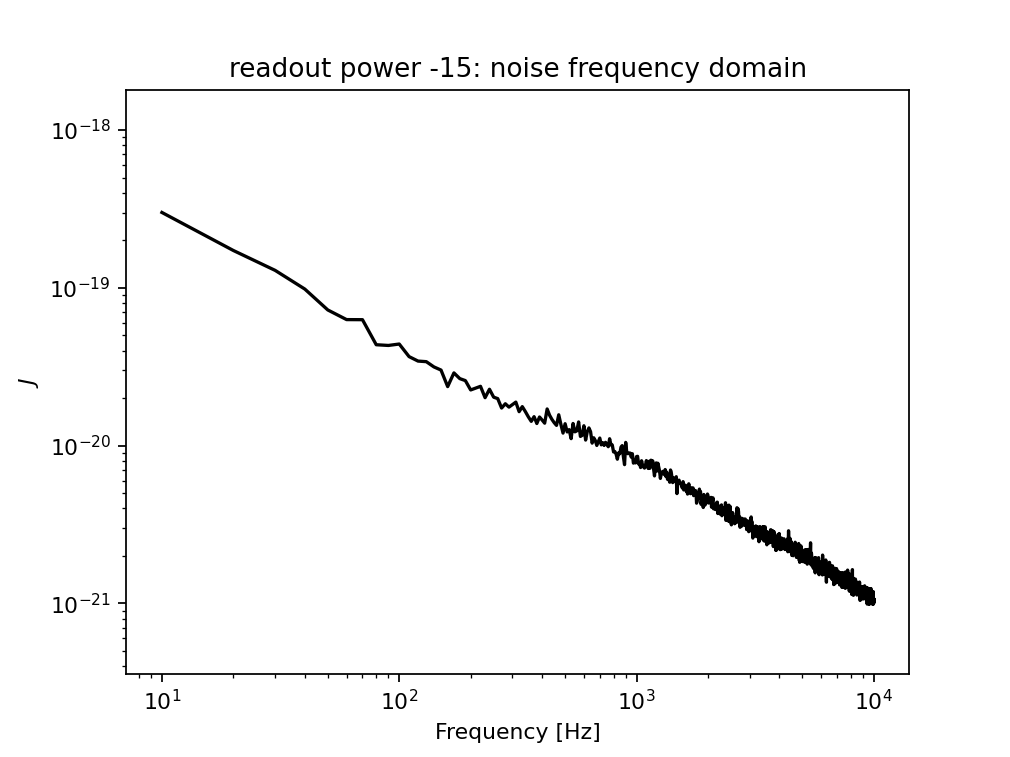

<IPython.core.display.Javascript object>


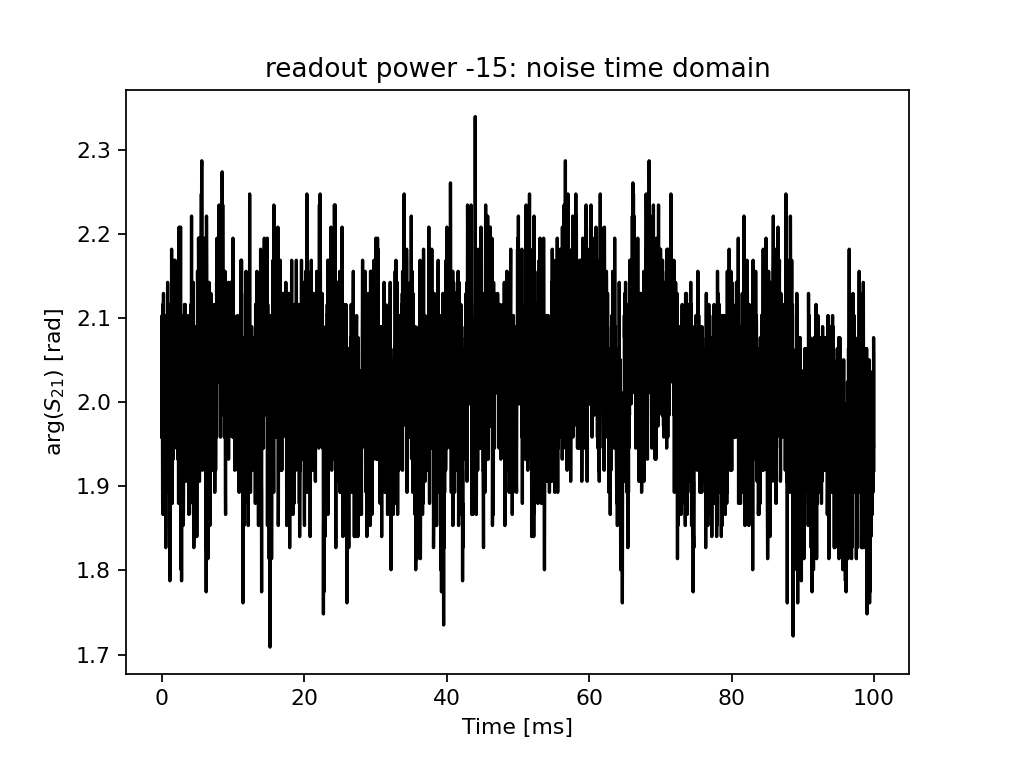

In [22]:
## Pick the lowest LED voltage data to use as noise template
J_avg, denominator, b7_res = oft.get_noise_template(LED_files[0], s, p_params, bad_pls_idxs, 
                                                    window_shift_J=window_shift_J, f_max=f_max)

In [23]:
# ## Pick the lowest LED voltage data to use as noise template
# nse_file_template = LED_files[0]
# print("Using file:",nse_file_template,"to characterize noise")

# ## Find the clean noise file, use the last one in the set that's been analyzed so far
# clean_noise_file = nse_file_template[:-3] + '_cleaned.h5'

# ## Open the cleaned data and pull the data sampling rate, pulse template, and pulse noise
# with h5py.File(clean_noise_file, "r") as fyle:
#     sampling_rate = np.array(fyle['sampling_rate'])          
#     pulse_noise   = np.array(fyle["df_f_pulse_noise"])

# ## Determine total period of the template and create a time-domain array and a freq-domain array
# T = N/sampling_rate
# time, f = Prf.build_t_and_f(N,sampling_rate)

# ## Determine how many samples to shift the window when calculating J
# samples_per_pulse  = sampling_rate*p_params['time_btw_pulse']
# window_shift_J_idx = int(window_shift_J*sampling_rate)
    
# ## Create a container to store J in temporarily
# J = np.zeros(N)
    
# ## Count how many good pulses there are in this file
# n_good_pulses = p_params['num_pulses'] - len(bad_pls_idxs[pulse_file])

# ## This defines where (in # of pulse windows) to start looking for pulse windows
# pulse_start = int(p_params['total_pulses'] * p_params['blank_fraction'])
# samples_per_pulse = int(p_params['time_btw_pulse']*sampling_rate)

# ## Loop over all the pulse windows in the file
# ## We want to skip the windows cut out when finding noise free region
# k = 0
# for pulse_i in range(pulse_start,int(p_params['total_pulses']),1):

#     ## Skip the bad pulse windows
#     if k in bad_pls_idxs[pulse_file]:
#         ## Increment the counter
#         k += 1
#         continue

#     ## Find the index for the end of this pulse window
#     pulse_i_end = int((pulse_i+1)*samples_per_pulse) 

#     ## Apply the window shift and an array of samples for the window timestream points
#     ## Are we really trying to find a pulse free region? seems like it
#     no_pulse_idx_start = pulse_i_end + window_shift_J_idx - N
#     no_pulse_idx_end   = pulse_i_end + window_shift_J_idx
#     no_pulse_idx_list  = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
#     no_pulse_noise_i   = pulse_noise[no_pulse_idx_list]

#     ## Caclulate the average J for this region
#     J += abs(Prf.discrete_FT(no_pulse_noise_i))**2 / n_good_pulses * 2 * T

#     ## Increment the counter
#     k += 1
    
# ## Determine the average J for plotting
# J_avg = np.mean(J)

# ## Calculate the denominator for the optimal filter
# denominator = np.sum(abs(s[f_mask])**2/J[f_mask])

# ## Calculate the baseline resolution
# b7_res = np.sqrt(((2*T*denominator)**-1))
# print("Baseline resolution:", b7_res)

# ## Plot the J we'll use for optimal filtering
# f2p0  = plt.figure()
# ax2p0 = f2p0.gca()
# plt.plot(f[f_plot],J[f_plot],color='k')#,zorder=-5*j+5,color='k')
# ax2p0.set_title(title + 'noise frequency domain')
# ax2p0.set_xlabel("Frequency [Hz]")
# ax2p0.set_ylabel(r"$J$")
# ax2p0.set_xscale('log')
# ax2p0.set_yscale('log')
# ax2p0.set_ylim([1e-1*J_avg,5e2*J_avg])

In [35]:
## Find the clean pulse file, use the last one in the set that's been analyzed so far
clean_pulse_file = LED_files[-1][:-3] + '_cleaned.h5'

with h5py.File(clean_pulse_file, "r") as fyle:
    pulse_avg = np.array(fyle['signal_template'])
    sampling_rate = np.array(fyle['sampling_rate'])

## Determine a window size equivalent to the full pulse template window
N = len(pulse_avg)
print(N, "samples per window")

## Determine total period of the template and create a time-domain array and a freq-domain array
T = N/sampling_rate
time, f = Prf.build_t_and_f(N,sampling_rate)

## Define a mask for evaluating fourier space components
f_mask = np.logical_and(f <= f_max, f >= -1*f_max)
N_mask = len(f[f_mask])
f_plot = np.logical_and(f > 0, f <= f_max)
new_fs = max(f[f_mask])

5000 samples per window


In [36]:
## Create an empty dataframe for the pulse amplitudes and prepare to save it to a file
f_name = series+"_OF_pulse_amps.h5"
f_path = os.path.join(datapath,f_name)

ampl_data = pd.DataFrame()
fit_data  = pd.DataFrame()
sum_data  = pd.DataFrame()
max_data  = pd.DataFrame()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.10000000000000002


<IPython.core.display.Javascript object>


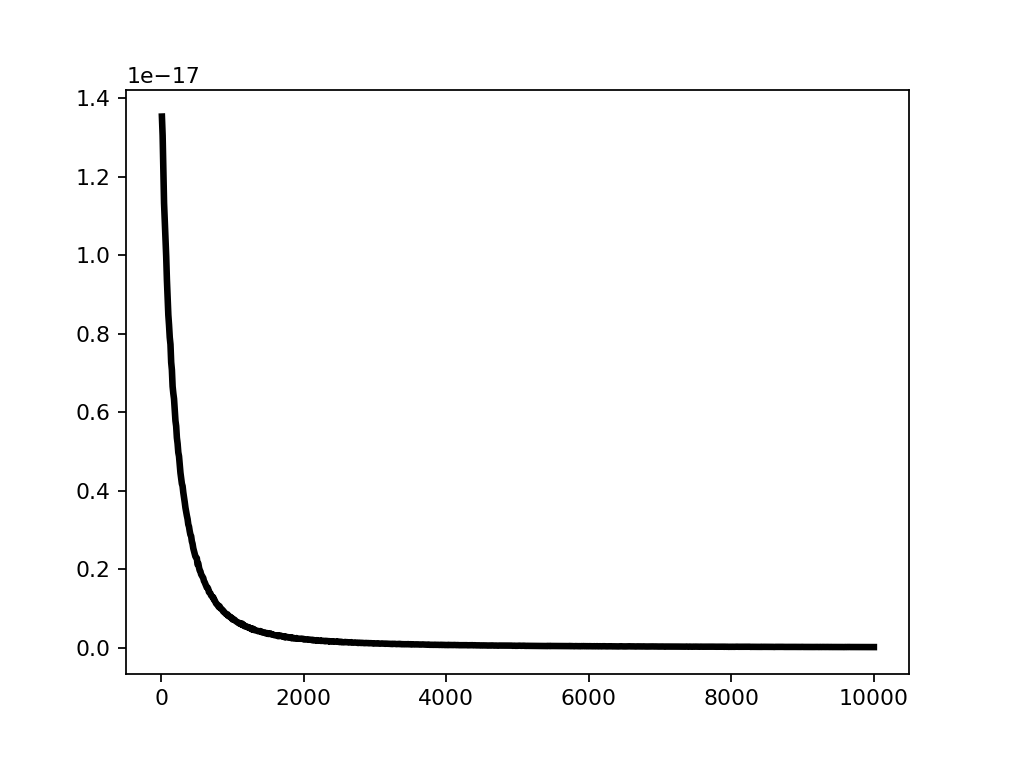

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10000000 but corresponding boolean dimension is 5000

In [37]:
verbose = False
# plt.rcParams.update({'font.size': 32})
window_shift=0

## Create titles for the plots
title      = r'$P_g=$' + str(p_params['rf_power']-line_atten_dB) + ' dBm: '
title_1    = title + 'signal template'
title_2    = title + 'noise power spectral density'
title_2    = 'noise power spectral densities'
title_2p2  = 'noise power spectral densities at lowest F'
title_2p1  = 'examples of V in time'
title_2p5  = 'index of IFFT with peak value'
title_3    = title + 'OF Pulse Amplitudes'
title_3p5  = title + 'cdf of pulse heights'
title_4    = title #+ 'sigma vs mu'

plt.figure(title_3, figsize=(14,4.5))
plt.figure(title_4, figsize=(14,5))

## Something to do about time offset between pulse window and singal template
offset_exponent = np.zeros((N_mask,N_mask),dtype=np.complex128)
time_ds = np.linspace(0,(N_mask-2)/(2*new_fs),N_mask)
print((N_mask-1)/(2*new_fs))
for j in range(N_mask):
    offset_exponent[j,:] = np.exp(1j*2*np.pi*f[f_mask][j]*time_ds)

for j in range(N_mask):
    for k in range(N_mask):
        if abs(offset_exponent[j,k].real) < 1e-10:
            offset_exponent[j,k] = 1j*offset_exponent[j,k].imag
        if abs(offset_exponent[j,k].imag) < 1e-10:
            offset_exponent[j,k] = offset_exponent[j,k].real

## Containers for ...
mu    = np.zeros(N_mask)
sigma = np.zeros(N_mask)

## Create containers to hold the means and standard deviations for the pulse height distribution
## for each of the pulse files
mus    = []
sigmas = []
J_at_min_f = np.array([])

## Start a loop over pulse files
j = 0
for pulse_file in LED_files[::-1]:
    if verbose: 
        print('=====================')
        print('analyzing data file: ' + pulse_file, "VLED=",Voltages[::-1][i])
    
#     color = cmap( (Voltages[::-1][j]-np.min(Voltages)) / (np.max(Voltages)-np.min(Voltages)) ) # 'C'+str(j%10)
    color = cmap( (Voltages[::-1][j]-1.5) / (np.max(Voltages)-1.5) ) # 'C'+str(j%10)
    
    ## Pull the average pulse and pulse PSDs from the cleaned pulse data file
    clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
    with h5py.File(clean_pulse_file, "r") as fyle:
        pulse_avg = np.array(fyle["full_timestream"])            
        pulse_noise = np.array(fyle["signal_template"])

    ## Recenter the average pulse
    pulse_recentered = pulse_avg # np.concatenate((pulse_avg[t_offset(N):],pulse_avg[:t_offset(N)]))
    
#     ## Fit the average pulse to an exponential
#     popt,pcov = curve_fit(exponential,time,pulse_recentered,p0=[1.2e-4,50e-6])
    
#     ## Calculate the best fit curve for the average pulse
#     pulse_fit = exponential(time,*popt)
    
    ## Get the frequency space of the average pulse
    s_temp = Prf.discrete_FT(pulse_recentered)
    
    ## Create a plot and store the signal template in f-space
    if j == 0:
        plt.figure(title_1)
        plt.plot(f[f_plot],abs(s[f_plot]**2),zorder=-5*j+5,color='k',linewidth=3)
        
    ## Focus the plot already containing the signal template, draw the average pulse for this file
    plt.figure(title_1)
    plt.plot(f[f_plot],abs(s_temp[f_plot]**2),zorder=-5*j+5,color=color)

    ## Determine how many samples to shift the window when calculating J
    samples_per_pulse  = sampling_rate*p_params['time_btw_pulse']
    window_shift_J_idx = int(window_shift_J*sampling_rate)
    
    ## Create a container to store J in temporarily
    J_temp = np.zeros(N)
    
    ## Count how many good pulses there are in this file
    n_good_pulses = p_params['num_pulses'] - len(bad_pls_idxs[pulse_file])

    ## Loop over all the pulse windows in the file
    ## Do we want to skip the windows cut out when finding average pulse? probably
    k = 0
    for pulse_i in range(pulse_start,int(p_params['total_pulses']),1):
        
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue
        
        ## Find the index for the end of this pulse window
        pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
        
        ## Apply the window shift and an array of samples for the window timestream points
        ## Are we really trying to find a pulse free region? seems like it
        no_pulse_idx_start = pulse_i_end + window_shift_J_idx - N
        no_pulse_idx_end   = pulse_i_end + window_shift_J_idx
        no_pulse_idx_list  = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
        no_pulse_noise_i   = pulse_noise[no_pulse_idx_list]
        
        ## Caclulate the average J for thid region
        J_temp += abs(Prf.discrete_FT(no_pulse_noise_i))**2 / n_good_pulses * 2 * T
        # J_temp += abs(fft.ifft(no_pulse_noise_i))**2 / num_pulses * 2 * T
        
        ## Increment the counter
        k += 1
        
    ## Plot the average J for this pulse file
    plt.figure(title_2)
    plt.plot(f[f_plot],J_temp[f_plot],zorder=-5*j+5,color=color)
    plt.plot(f[f_plot],J[f_plot],zorder=-5*j+5,color="k")
    
    plt.figure(title_2p2)
    plt.scatter(Voltages[::-1][j],J_temp[f_plot][0],zorder=-5*j+5,color=color)
    J_at_min_f = np.append(J_at_min_f, J_temp[f_plot][0])
#     plt.plot(f[f_plot],J_temp[f_plot],zorder=-5*j+5,color=('k' if j==0 else color))

    ## Create containers for our output related to pulse height
    ## One entry for every pulse window, not using cuts on baseline
    A_hat     = np.zeros((n_good_pulses,N_mask))
    A_max_idx = np.zeros(n_good_pulses)
    A_hat_max = np.zeros(n_good_pulses)
    A_hat_sum = np.zeros(n_good_pulses)
    
    ## Not sure that we want to apply an offset because of how we did things earlier?
    ## We want the rising edge of the pulse centered
    t_offset_idx = 0 # t_offset(N_mask) # 
    
    ## Initialize a counter and loop over every pulse window
    ## Again, do we want to skip the regions we cut earlier? probably not
    k = 0 ; jj = 0
    for pulse_i in range(pulse_start,int(p_params['total_pulses']),1):
        
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue
        
        ## Apply the window shift and an array of samples for the window timestream points
        ## This is the same window shift defined in the pulse averaging code block
        pulse_i_start   = int(pulse_i*samples_per_pulse)
        pulse_idx_start = pulse_i_start + window_shift
        pulse_idx_end   = pulse_idx_start + N
        pulse_idx_list  = np.arange(pulse_idx_start,pulse_idx_end,1,dtype=int)
        pulse_noise_i   = pulse_noise[pulse_idx_list]
        
        # pulse_noise_i_recentered = np.concatenate((pulse_noise_i[N//2:],pulse_noise_i[:N//2]))

        ## Fourier transform the baseline-subtracted window
        v = Prf.discrete_FT(pulse_noise_i - np.mean(pulse_noise_i[:20])) 
#         v = Prf.discrete_FT(pulse_noise_i - np.mean(pulse_noise_i[-5:])) 
        
        ## Apply the window shift and an array of samples for the window timestream points
        ## for the pulse free region
        pulse_i_end        = int((pulse_i+1)*samples_per_pulse) 
        no_pulse_idx_start = pulse_i_end + window_shift_J_idx - N 
        no_pulse_idx_end   = pulse_i_end + window_shift_J_idx
        no_pulse_idx_list  = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
        no_pulse_noise_i   = pulse_noise[no_pulse_idx_list]
        
        ## Fourier transform the baseline-subtracted pulse-free window
        v_temp = Prf.discrete_FT(no_pulse_noise_i)

        ## Plot some number of pulses in the template pulse file
        if j == 0 and (pulse_i + 0) % 20 == 0:
            plt.figure(title_2p1)
            plt.plot(time*1e3,pulse_noise_i,alpha=0.3)#color='k')

        ## Calculate the numerator of the optimal filter 
        numerator = Prf.discrete_IFT(np.conj(s[f_mask])*v[f_mask]/J[f_mask])
        numerator = numerator.real

        ## Calculate the sum in the numerator of the optimal filter
        numerator_sum = sum(offset_exponent[:,t_offset_idx]*np.conj(s[f_mask])*v_temp[f_mask]/J[f_mask])
        numerator_sum = numerator_sum.real
      
        ## Find the maximum of the optimal filter numerator
        max_numerator = max(numerator)
        max_idx = np.argwhere(numerator == max_numerator)

        ## Calculate the optimal filter
        A_max_idx[jj] = max_idx 
        A_hat[jj,:]   = numerator / denominator
        A_hat_max[jj] = max_numerator/denominator
        A_hat_sum[jj] = numerator_sum / denominator
        
        ## Increment the counter
        k += 1 ; jj += 1
        
    ## Loop over the points in the mask and fit the OF to a gaussian, extracting the mean and sigma
    for fp in range(N_mask):
        (mu[fp], sigma[fp]) = norm.fit(A_hat[:,fp])
    
    ## If we are on the template file define the optimal t0 for the pulse
    optimal_t0 = t_offset_idx
        
    ## fit the OF max and sum to a gaussian, extracting the mean and sigma
    (mu_max, sigma_max) = norm.fit(A_hat_max)
    (mu_sum, sigma_sum) = norm.fit(A_hat_sum)
    
    ## Print the mean and sigma from the OF fit
    print('mu = ' + "{:.2e}".format(mu[t_offset_idx]) + '; sigma = ' + "{:.2e}".format(sigma[t_offset_idx])+ '; sigma_0 = ' + "{:.3e}".format(b7_res))         

    ## Draw the histograms of maximum amplitude index in the FFT spectra
    plt.figure(title_2p5)
    n, bins, patches = plt.hist(A_max_idx,bins=N,fill=False,histtype='step',label='radians',color=color)
        
    if (j+0) % 1 == 0: # True: # 
        # print(LED_files[j])
        
        ## Get the current array of optimal pulse heights
        data = A_hat[:,optimal_t0]
        nbins = 20 # 100
        
        ## Save this data to the dataframes
        data_filled = -999*np.ones(1000)
        data_filled[:len(data)] = data
        
        ampl_data[str(Voltages[::-1][j])] = data_filled
        fit_data[ str(Voltages[::-1][j])] = np.array([mu[optimal_t0],sigma[optimal_t0]])
        sum_data[ str(Voltages[::-1][j])] = np.array([mu_sum,sigma_sum])
        max_data[ str(Voltages[::-1][j])] = np.array([mu_max,sigma_max])
        
        ## Create the histograms of pulse heights and draw fits
        plt.figure(title_3)
        if j == 0:
            n, bins, patches = plt.hist(data,bins=nbins,fill=False,histtype='step',label='radians',color=color,density=1.0)
            bin_width = bins[1]-bins[0]
        else:
            n, bins, patches = plt.hist(data,bins=np.arange(min(data), max(data) + bin_width, bin_width),fill=False,histtype='step',label='radians',color=color,density=1.0)
            
        plt.plot(np.linspace(bins[0],bins[-1],100),\
                 norm.pdf(np.linspace(bins[0],bins[-1],100),mu[optimal_t0],sigma[optimal_t0]),\
                 c='gray')
        
        ## Manipulate the data to compare CDFs
        data_sorted = np.sort(data)[2:-2]
        xdata = data_sorted - np.min(data_sorted)
        xdata = xdata/np.max(xdata)
        ydata = np.cumsum(xdata)/np.sum(xdata)
        
        ## Create the CDF plots
        plt.figure(title_3p5)
        plt.step(xdata,ydata,where='post',color=color)

    ## Write the fit results to the containers
    mus.append(mu[optimal_t0]); sigmas.append(sigma[optimal_t0])

    plt.figure(title_4)
    if j == 0:
        label1 = 'triggering on signal'
        label2 = 'triggering on noise'
    else:
        label1 = None
        label2 = None
    plt.plot(mu[optimal_t0],sigma[optimal_t0],color=color,ls=None,marker='s',label=label1)
    plt.plot(mu_sum,        sigma_sum,        color=color,ls=None,marker='s',label=label2,markersize=4,markeredgecolor='k')

    ## Increment the counter for pulse files
    j += 1

## Format the plots
plt.figure(title_1)
ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log')
plt.title(title_1)

plt.figure(title_2)
ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log')
J_avg = np.mean(J)
plt.ylim([1e-1*J_avg,1e2*J_avg])
plt.title(title_2)

plt.figure(title_2p1)
plt.title(title_2p1)
plt.xlabel("Time [ms]")

plt.figure(title_2p2)
plt.title(title_2p2)
plt.xlabel("LED Voltage [V]")
plt.ylabel(r"$J(f=f_\mathrm{min})$")

line = lambda x, m, b: m*x + b
min_fit_idx = 0

xdata = Voltages[::-1][:-3]
ydata = J_at_min_f[:-3]
print(xdata)
print(ydata)
popt, pcov = curve_fit( line , xdata, ydata, p0=[0.04, -0.04] ) # p0=[0.4e-19, -0.4e-19] )
plt.plot(Voltages, line(Voltages,popt[0],popt[1]), 'k-',label="Slope: "+str(popt[0]))
plt.legend(loc='best')

plt.figure(title_2p5)
plt.title(title_2p5)
plt.xlabel(r'index of IFFT($\frac{s^*v}{J}$)')

plt.figure(title_3)
plt.title(title_3)
plt.xlabel('Pulse Amplitude (normalized to tallest pulse)')
plt.ylabel('Density')
if False:
    ylim = plt.gca().get_ylim()
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e0,ylim[1]])

plt.figure(title_3p5)
plt.title(title_3p5)
plt.xlabel('normalized pulse height range')
plt.ylabel('cumulative distribution')
plt.gca().set_ylim([-0.1,1.1])

plt.figure(title_4)
plt.title(title_4)
plt.axhline(b7_res,color='grey',label='baseline resolution')
# plt.xlabel('Pulse Amplitude (normalized to tallest pulse)'),#fontsize=18)
plt.xlabel(r'$\mu$')#,fontsize=18)
plt.ylabel(r'$\sigma$')#,fontsize=18)
plt.tight_layout()

plt.figure()
print(sigma.shape)
for j in range(N_mask):
    plt.plot(np.mean(sigma,axis=0))
    plt.plot(optimal_t0,np.mean(sigma[optimal_t0]),ls='',marker='.',color='k')
# print(np.mean(np.mean(sigma[-8:])))
plt.xlabel('time offset')
plt.ylabel('OF noise')
plt.title('triggering on noise before pulse')
# plt.savefig('triggering_on_noise_after_pulse',dpi=300,facecolor='white',transparent=False)

def sig(mu,sigma_0,r):
    return np.sqrt(sigma_0**2 + (mu)*r)
#     return np.sqrt(b7_res**2 + (mu)*r)

def sig2(mu,sigma_0,r):
    return np.sqrt(b7_res**2 + (mu)*r)


mus = np.array(mus)
sigmas = np.array(sigmas)

# p0 = [1e-1,1e-9]
p0 = [1e-1,1e-2]
# f_fit_vals,_ = curve_fit(f,mu,sigma,p0,bounds=[(15*(0.008/2.6),7e-3),(40*(0.008/2.6),0.1)])
# f_fit_vals,_ = curve_fit(sig,mus[sigmas<0.035],sigmas[sigmas<0.035],p0)
f_fit_vals,_ = curve_fit(sig,mus,sigmas,p0)
print(np.max(sigma))
# f_fit_vals,_ = curve_fit(sig2,mu,[p0[1]])

sigma_0_E_pub = abs(f_fit_vals[0])/(f_fit_vals[1]/2.61)
# sigma_0_E_pub = abs(b7_res)/(f_fit_vals[1]/2.61)

print(b7_res)
# sigma_0_E_pub = abs(b7_res)/(f_fit_vals[1]/2.61)
print('energy resolution estimate is: ' + str(sigma_0_E_pub))
print(*f_fit_vals)

mu_plot = np.linspace(0,1.0,100)#5.5e-7,100)
plt.figure(title_4)
# plt.plot(mus,np.array(sigmas),ls=None) ## Blue connecting line
plt.plot(mu_plot,sig(mu_plot,*f_fit_vals),label='$\sigma_0$='+str(round(sigma_0_E_pub,1))+'eV')#,ls=None)
plt.plot(mu_plot,sig2(mu_plot,*f_fit_vals),label='$\sigma_0$='+str(round(abs(b7_res)/(f_fit_vals[1]/2.64),1))+'eV')
# custom_lines = [\
#             #Line2D([0], [0],color='k',ls='',marker='.',label='max of IFT'),\
#             #Line2D([0], [0], color='k',alpha=0.5, ls='dashdot',label='radius and arc length directions'),\
#             Line2D([0], [0],color='k',ls='',marker='s',label='index 0'),]
#             #Line2D([0], [0], ls='',color='C1', marker='.',label='off resonance timestream')]
# #     plt.legend(handles=custom_lines)
plt.legend(loc='best',fontsize=20)
# plt.ylim([0,0.05])
# plt.gca().set_xlim([plt.gca().set_xlim()[0],1.1])
plt.tight_layout()
# plt.savefig('sigma_vs_mu.png',dpi=200)

ampl_data.to_hdf(f_path,"data")
fit_data.to_hdf(f_path,"fit")
sum_data.to_hdf(f_path,"sum")
max_data.to_hdf(f_path,"max")
pd.DataFrame({"b7_res":np.array([b7_res])}).to_hdf(f_path,"b7_res")
pd.DataFrame({"r_fit":np.array([f_fit_vals[1]])}).to_hdf(f_path,"r_fit")